In [1]:
import os
import numpy as np
import random
import csv
import re
from anytree import Node, RenderTree


In [2]:
data_dir = 'output_dir/'
train_file = os.path.join(data_dir, 'basic_train.tsv')
val_file = os.path.join(data_dir, 'basic_val.tsv')
test_file = os.path.join(data_dir, 'basic_test.tsv')

In [3]:
def load_listops_data(file_path, max_rows=None):
    """
    Load ListOps data from TSV file.
    
    Args:
        file_path: Path to the TSV file
        max_rows: Maximum number of rows to load (for testing)
    
    Returns:
        sources: Array of source expressions
        targets: Array of target values (0-9)
    """
    sources = []
    targets = []
    
    with open(file_path, 'r', encoding='utf-8') as f:
        next(f)  # Skip header (Source, Target)
        for i, line in enumerate(f):
            if max_rows and i >= max_rows:
                break
            
            source, target = line.strip().split('\t')
            sources.append(source)
            targets.append(int(target))  # Target is always 0-9
    
    # Convert to numpy arrays
    source_array = np.array(sources, dtype=object)  # Keep expressions as strings
    target_array = np.array(targets, dtype=np.int32)  # Targets are integers
    
    return source_array, target_array


In [4]:

try:
    print("Loading training data...")
    X_train, y_train = load_listops_data(train_file)
    
    print("Loading validation data...")
    X_val, y_val = load_listops_data(val_file)
    
    print("Loading test data...")
    X_test, y_test = load_listops_data(test_file)
    
    print("\nDataset sizes:")
    print(f"Training: {len(X_train)} examples")
    print(f"Validation: {len(X_val)} examples")
    print(f"Test: {len(X_test)} examples")
    combined_targets = np.concatenate((y_train, y_val, y_test))
    unique, counts = np.unique(combined_targets, return_counts=True)

    print("\nCombined Target Value Distribution:")
    for value, count in zip(unique, counts):
        print(f"Class {value}: {count} examples ({(count / len(combined_targets)) * 100:.2f}%)")

   
    
except Exception as e:
    print(f"Error occurred: {type(e).__name__}: {str(e)}")

Loading training data...
Loading validation data...
Loading test data...

Dataset sizes:
Training: 96000 examples
Validation: 2000 examples
Test: 2000 examples

Combined Target Value Distribution:
Class 0: 17042 examples (17.04%)
Class 1: 9047 examples (9.05%)
Class 2: 7591 examples (7.59%)
Class 3: 8507 examples (8.51%)
Class 4: 8988 examples (8.99%)
Class 5: 8435 examples (8.43%)
Class 6: 7743 examples (7.74%)
Class 7: 7285 examples (7.29%)
Class 8: 8628 examples (8.63%)
Class 9: 16734 examples (16.73%)


In [5]:
percentages = (counts / len(combined_targets)) * 100

print("Shape of unique:", unique.shape)
print("Shape of percentages:", percentages.shape)
print("\nUnique values:", unique)
print("Percentages:", percentages)

Shape of unique: (10,)
Shape of percentages: (10,)

Unique values: [0 1 2 3 4 5 6 7 8 9]
Percentages: [17.042  9.047  7.591  8.507  8.988  8.435  7.743  7.285  8.628 16.734]


[17.042  9.047  7.591  8.507  8.988  8.435  7.743  7.285  8.628 16.734]
[0 1 2 3 4 5 6 7 8 9]


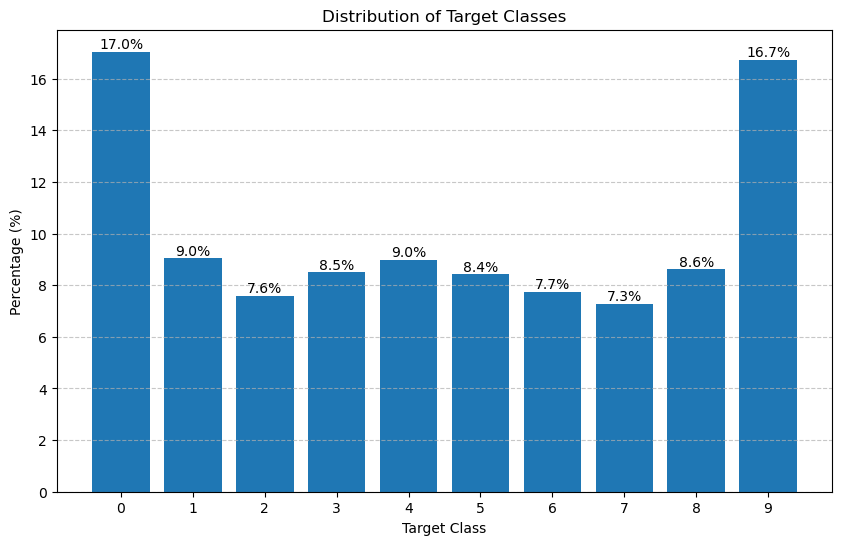

In [6]:
import matplotlib.pyplot as plt

# Calculate percentages
percentages = (counts / len(combined_targets)) * 100
print(percentages)
# Create bar plot
plt.figure(figsize=(10, 6))
print(unique)
plt.bar(unique, percentages)
# Customize the plot
plt.title('Distribution of Target Classes')
plt.xlabel('Target Class')
plt.ylabel('Percentage (%)')

# Add percentage labels on top of each bar
for i, percentage in enumerate(percentages):
    plt.text(unique[i], percentage, f'{percentage:.1f}%', 
             ha='center', va='bottom')

# Ensure x-axis shows all class values
plt.xticks(unique)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [7]:


def evaluate_tree(tokens, pos=0):
    """
    Evaluate a ListOps expression following the original generation rules.
    
    Operators:
    - [MIN: minimum of arguments
    - [MAX: maximum of arguments
    - [MED: median of arguments (using int(np.median()))
    - [SM: sum of arguments modulo 10
    """
    def collect_args(start_pos):
        args = []
        current_pos = start_pos
        
        while current_pos < len(tokens):
            token = tokens[current_pos]
            
            if token.startswith('['):  # Operator
                value, next_pos = evaluate_tree(tokens, current_pos)
                if value is not None:
                    args.append(value)
                current_pos = next_pos
            elif token.isdigit():  # Number
                args.append(int(token))
                current_pos += 1
            elif token == ']':  # End of current operation
                return args, current_pos + 1
            else:  # Skip other tokens (parentheses)
                current_pos += 1
                
        return args, current_pos
    
    if pos >= len(tokens):
        return None, pos
    
    current_token = tokens[pos]
    if current_token == '[MIN':
        args, next_pos = collect_args(pos + 1)
        return min(args), next_pos
    elif current_token == '[MAX':
        args, next_pos = collect_args(pos + 1)
        return max(args), next_pos
    elif current_token == '[MED':
        args, next_pos = collect_args(pos + 1)
        return int(np.median(args)), next_pos
    elif current_token == '[SM':
        args, next_pos = collect_args(pos + 1)
        return sum(args) % 10, next_pos
    
    return None, pos + 1

def tokenize(expression):
    """
    Convert expression string to tokens, preserving operators.
    """
    # Replace parentheses with spaces
    expr = expression.replace('(', ' ').replace(')', ' ')
    
    # Add spaces around brackets that aren't part of operators
    expr = re.sub(r'\[(?!(MIN|MAX|MED|SM))', ' [ ', expr)
    expr = expr.replace(']', ' ] ')
    
    # Split and filter empty strings
    return [token for token in expr.split() if token]

def validate_examples(X, y, num_examples=3):
    """
    Validate examples by comparing calculated results with targets.
    """
    print(f"\nValidating {num_examples} examples:\n")
    
    for i in range(min(num_examples, len(X))):
        print("=" * 80)
        print(f"Example {i+1}:")
        
        expr = X[i]
        tokens = tokenize(expr)
        
        print(f"\nExpression (first 100 chars):")
        print(expr[:100], "...")
        print(f"Target value: {y[i]}")
        
        try:
            calculated, _ = evaluate_tree(tokens)
            print(f"Calculated value: {calculated}")
            print(f"Matches target: {calculated == y[i]}")
            
            # Show first few tokens for debugging
            print(f"\nFirst few tokens: {tokens[:10]}")
            
        except Exception as e:
            print(f"Calculation error: {type(e).__name__}: {str(e)}")
            print(f"Error details: {str(e)}")
        
        print()

try:
    # Validate first few examples
    validate_examples(X_train, y_train, num_examples=3)
    
    # Print overall validation statistics
    if len(X_train) > 0:
        correct = 0
        total = min(100, len(X_train))  # Check first 100 examples
        
        print(f"\nValidating first {total} examples...")
        for i in range(total):
            try:
                calculated, _ = evaluate_tree(tokenize(X_train[i]))
                if calculated == y_train[i]:
                    correct += 1
            except Exception:
                continue
        
        print(f"Accuracy on {total} examples: {correct/total*100:.1f}%")
    
except Exception as e:
    print(f"Error occurred: {type(e).__name__}: {str(e)}")


Validating 3 examples:

Example 1:

Expression (first 100 chars):
( ( ( ( ( ( ( ( ( ( [MIN 1 ) ( ( ( ( ( ( ( ( [MED 8 ) 0 ) 1 ) 3 ) 0 ) 6 ) 1 ) ] ) ) 7 ) ( ( ( ( ( (  ...
Target value: 1
Calculated value: 1
Matches target: True

First few tokens: ['[MIN', '1', '[MED', '8', '0', '1', '3', '0', '6', '1']

Example 2:

Expression (first 100 chars):
( ( ( ( ( ( ( ( ( ( [MAX 1 ) 8 ) 3 ) 0 ) 0 ) 9 ) 5 ) 8 ) ( ( ( ( ( ( ( ( ( ( ( [MIN 9 ) 6 ) ( ( ( (  ...
Target value: 9
Calculated value: 9
Matches target: True

First few tokens: ['[MAX', '1', '8', '3', '0', '0', '9', '5', '8', '[MIN']

Example 3:

Expression (first 100 chars):
( ( ( ( ( [SM 2 ) ( ( ( ( ( ( ( [MED 6 ) ( ( ( ( ( ( [SM ( ( ( [MAX 2 ) 9 ) ] ) ) 4 ) 2 ) 5 ) ( ( (  ...
Target value: 4
Calculated value: 4
Matches target: True

First few tokens: ['[SM', '2', '[MED', '6', '[SM', '[MAX', '2', '9', ']', '4']


Validating first 100 examples...
Accuracy on 100 examples: 100.0%


In [8]:
MIN = '[MIN'
MAX = '[MAX'
MED = '[MED'
FIRST = '[FIRST'
LAST = '[LAST'
SUM_MOD = '[SM'
END = ']'

OPERATORS = [MIN, MAX, MED, SUM_MOD]  # , FIRST, LAST]
VALUES = range(10)
VALUE_P = 0.25


In [9]:

def to_string(t, parens=True):
  if isinstance(t, str):
    return t
  elif isinstance(t, int):
    return str(t)
  else:
    if parens:
      return '( ' + to_string(t[0]) + ' ' + to_string(t[1]) + ' )'


def to_value(t):
  """Compute the output of equation t.

  Args:
    t: a tree structure that represents equation t, list.

  Returns:
    The result of equation t, int.
  """
  if not isinstance(t, tuple):
    return t
  l = to_value(t[0])
  r = to_value(t[1])
  if l in OPERATORS:  # Create an unsaturated function.
    return (l, [r])
  elif r == END:  # l must be an unsaturated function.
    if l[0] == MIN:
      return min(l[1])
    elif l[0] == MAX:
      return max(l[1])
    elif l[0] == FIRST:
      return l[1][0]
    elif l[0] == LAST:
      return l[1][-1]
    elif l[0] == MED:
      return int(np.median(l[1]))
    elif l[0] == SUM_MOD:
      return np.sum(l[1]) % 10
  elif isinstance(l, tuple):
    # We've hit an unsaturated function and an argument.
    return (l[0], l[1] + [r])

In [10]:

def visualize_tree(t, parent=None):
    """
    Convert the tuple tree to anytree Node structure for visualization.
    
    Args:
        t: The tuple tree structure
        parent: Parent node (used in recursion)
    
    Returns:
        Root node of the anytree structure
    """
    if isinstance(t, (int, str)):
        return Node(str(t), parent=parent)
    
    # Handle the special case of the END marker
    if t[1] == END:
        op, args = extract_operator_and_args(t[0])
        if parent is None:
            root = Node(str(op))
            for arg in args:
                visualize_tree(arg, root)
            return root
        else:
            node = Node(str(op), parent=parent)
            for arg in args:
                visualize_tree(arg, node)
            return node
    
    return visualize_tree(t[0], parent)

def extract_operator_and_args(t):
    """
    Extract the operator and its arguments from a nested tuple structure.
    
    Args:
        t: A tuple containing an operator and its arguments
        
    Returns:
        tuple: (operator, list of arguments)
    """
    if not isinstance(t, tuple):
        return t, []
    
    if isinstance(t[0], str) and t[0] in OPERATORS:
        return t[0], [t[1]]
    
    op, args = extract_operator_and_args(t[0])
    return op, args + [t[1]]


In [11]:
def visualize_tree(expression):
    """
    Convert a ListOps expression string into an anytree Node structure for visualization.
    
    Args:
        expression: String containing the ListOps expression
        
    Returns:
        Root node of the anytree structure
    """
    def build_tree(tokens, pos=0, parent=None):
        """
        Recursively build tree from tokens starting at pos.
        Returns (node, new_pos)
        """
        if pos >= len(tokens):
            return None, pos
            
        token = tokens[pos]
        
        # Handle operators
        if token.startswith('['):
            operator = Node(token, parent=parent)
            current_pos = pos + 1
            
            # Collect all arguments until matching ']'
            while current_pos < len(tokens):
                if tokens[current_pos] == ']':
                    return operator, current_pos + 1
                    
                # Skip parentheses
                elif tokens[current_pos] in ['(', ')']:
                    current_pos += 1
                    continue
                    
                # Recursively build subtree for this argument
                child_node, next_pos = build_tree(tokens, current_pos, operator)
                if child_node is None:
                    break
                current_pos = next_pos
                
            return operator, current_pos
            
        # Handle numbers
        elif token.isdigit():
            return Node(token, parent=parent), pos + 1
            
        # Skip parentheses
        elif token in ['(', ')']:
            return build_tree(tokens, pos + 1, parent)
            
        return None, pos + 1

    # Tokenize the expression
    tokens = tokenize(expression)
    
    # Build the tree starting from the first meaningful token
    root, _ = build_tree(tokens)
    return root

def print_tree(expression):
    """
    Print a visual representation of the ListOps expression tree.
    
    Args:
        expression: String containing the ListOps expression
    """
    root = visualize_tree(expression)
    
    # Print the tree structure
    for pre, _, node in RenderTree(root):
        print(f"{pre}{node.name}")

def save_tree_to_file(expression, output_file):
    """
    Save a visual representation of the ListOps expression tree to a file.
    
    Args:
        expression: String containing the ListOps expression
        output_file: Path to the output file
    """
    root = visualize_tree(expression)
    
    # Open file in write mode
    with open(output_file, 'w', encoding='utf-8') as f:
        # Write the tree structure to file
        for pre, _, node in RenderTree(root):
            f.write(f"{pre}{node.name}\n")
      

In [12]:
expression = X_train[0]  
print_tree(expression)
save_tree_to_file(expression, 'tree.txt')

[MIN
├── 1
├── [MED
│   ├── 8
│   ├── 0
│   ├── 1
│   ├── 3
│   ├── 0
│   ├── 6
│   └── 1
├── 7
├── [MED
│   ├── [SM
│   │   ├── 4
│   │   ├── [MED
│   │   │   ├── [SM
│   │   │   │   ├── 2
│   │   │   │   ├── 9
│   │   │   │   ├── [MED
│   │   │   │   │   ├── 9
│   │   │   │   │   ├── 9
│   │   │   │   │   ├── 2
│   │   │   │   │   ├── [MIN
│   │   │   │   │   │   ├── 8
│   │   │   │   │   │   ├── 3
│   │   │   │   │   │   ├── 5
│   │   │   │   │   │   ├── 4
│   │   │   │   │   │   ├── 8
│   │   │   │   │   │   ├── 5
│   │   │   │   │   │   ├── 6
│   │   │   │   │   │   ├── 2
│   │   │   │   │   │   ├── 6
│   │   │   │   │   │   └── 0
│   │   │   │   │   ├── 5
│   │   │   │   │   └── 8
│   │   │   │   ├── 2
│   │   │   │   ├── 6
│   │   │   │   ├── 8
│   │   │   │   ├── 9
│   │   │   │   └── 8
│   │   │   ├── 3
│   │   │   ├── 4
│   │   │   ├── [SM
│   │   │   │   ├── 3
│   │   │   │   ├── [SM
│   │   │   │   │   ├── [MIN
│   │   │   │   │   │   ├── [MIN
│   │   │   │   │   │   │   ├─

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class ListOpsDataset(Dataset):
    def __init__(self, X, y, max_length=2000):
        """
        Args:
            X: Array of source expressions
            y: Array of target values
            max_length: Maximum sequence length (will pad/truncate to this)
        """
        self.X = X
        self.y = y
        self.max_length = max_length
        
        # Create vocabulary from operators and digits
        self.vocab = {
            'PAD': 0,  # Padding token
            '[MIN': 1,
            '[MAX': 2,
            '[MED': 3,
            '[SM': 4,
            ']': 5,
            '(': 6,
            ')': 7
        }
        # Add digits 0-9
        for i in range(10):
            self.vocab[str(i)] = i + 8
            
    def __len__(self):
        return len(self.X)
    
    def tokenize(self, expr):
        """Convert expression to token IDs."""
        tokens = tokenize(expr)  # Using our previous tokenize function
        return [self.vocab.get(token, 0) for token in tokens]
    
    def __getitem__(self, idx):
        expr = self.X[idx]
        target = self.y[idx]
        
        # Convert to token IDs
        token_ids = self.tokenize(expr)
        
        # Pad or truncate to max_length
        if len(token_ids) > self.max_length:
            token_ids = token_ids[:self.max_length]
        else:
            token_ids = token_ids + [self.vocab['PAD']] * (self.max_length - len(token_ids))
        
        return {
            'input_ids': torch.tensor(token_ids, dtype=torch.long),
            'target': torch.tensor(target, dtype=torch.long)
        }

# Create datasets
train_dataset = ListOpsDataset(X_train, y_train)
val_dataset = ListOpsDataset(X_val, y_val)
test_dataset = ListOpsDataset(X_test, y_test)

# Create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Verify the data
print("Dataset sizes:")
print(f"Train: {len(train_dataset)}")
print(f"Val: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")

# Check first batch
batch = next(iter(train_loader))
print("\nFirst batch shape:")
print(f"Input IDs: {batch['input_ids'].shape}")
print(f"Targets: {batch['target'].shape}")